In [17]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.model_selection import KFold

In [18]:
# =============================================================================
# CARICAMENTO DATI
# =============================================================================

signal_path = "data/atlas/signal_clusters.npy"
noise_path = "data/atlas/noise_clusters.npy"

signal_clusters = np.load(signal_path, allow_pickle=True).tolist()
noise_clusters = np.load(noise_path, allow_pickle=True).tolist()
print("Dati caricati da file numpy.")


Dati caricati da file numpy.


In [19]:
# =============================================================================
# Funzione per estrazione delle feature
# =============================================================================

def extract_features(c):
    total_charge = [np.sum(cluster) for cluster in c["charge"]]
    x = c["localPosX"]
    mean_time = [np.average(t, weights=q) for t, q in zip(c["stripTimes"], c["charge"])]
    n_strips = [len(cluster) for cluster in c["charge"]]
    features = np.stack([total_charge, x, mean_time, n_strips], axis=1)

    global_x = c["globalPosX"]
    global_y = c["globalPosY"]
    global_z = c["globalPosZ"]
    global_positions = np.stack([global_x, global_y, global_z], axis=1)

    return features, global_positions


In [20]:
# =============================================================================
# CREAZIONE DEI GRAFICI
# =============================================================================

event_graphs = []
k = 4  # numero di vicini per il grafo

def create_graphs(clusters, label):
    for c in clusters:
        features, global_positions = extract_features(c)
        if len(features) < 2:
            continue
        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(np.full(features.shape[0], label), dtype=torch.long)
        pos = torch.tensor(global_positions, dtype=torch.float)
        coords = global_positions
        N = x.shape[0]
        nbrs = NearestNeighbors(n_neighbors=min(k+1, N), algorithm='ball_tree').fit(coords)
        _, indices = nbrs.kneighbors(coords)
        edge_index = []
        for idx, neighbors in enumerate(indices):
            for n in neighbors[1:]:
                edge_index.append([idx, n])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        event_graphs.append(Data(x=x, edge_index=edge_index, y=y, pos=pos))

create_graphs(signal_clusters, label=1)
create_graphs(noise_clusters, label=0)

print(f"Numero di eventi/grafi creati: {len(event_graphs)}")


Numero di eventi/grafi creati: 20000


In [21]:

# === Divisione train/val/test ===
train_graphs, temp_graphs = train_test_split(event_graphs, test_size=0.4, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)
print(f"Train set: {len(train_graphs)} eventi, Validation set: {len(val_graphs)} eventi, Test set: {len(test_graphs)} eventi")


Train set: 12000 eventi, Validation set: 4000 eventi, Test set: 4000 eventi


In [22]:

# === Normalizzazione delle feature ===
all_train_features = np.concatenate([data.x.numpy() for data in train_graphs], axis=0)
mean = all_train_features.mean(axis=0)
std = all_train_features.std(axis=0)

def normalize_features(features, mean, std):
    return (features - mean) / std

for dataset in [train_graphs, val_graphs, test_graphs]:
    for data in dataset:
        data.x = torch.tensor(normalize_features(data.x.numpy(), mean, std), dtype=torch.float)


In [23]:

# =============================================================================
# DEFINIZIONE MODELLO GNN
# =============================================================================

class GNN(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=64, out_channels=1, num_layers=3, dropout=0.2):
        super().__init__()
        self.pre_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU()
        )
        self.convs = nn.ModuleList([GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.post_mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.pre_mlp(x)
        for conv in self.convs:
            x_res = x
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
            x = x + x_res 
        x = self.post_mlp(x)
        return x.view(-1)


In [24]:
# =============================================================================
# INIZIALIZZAZIONE E LOSS
# =============================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = GNN(in_channels=4, hidden_channels=32, out_channels=1, num_layers=4, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCEWithLogitsLoss()

train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=16)
test_loader = DataLoader(test_graphs, batch_size=16)

Using device: cuda


In [25]:
# =============================================================================
# SALVATAGGIO E CARICAMENTO MODELLO
# =============================================================================

def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Modello finale salvato in {path}")

def load_model(model, optimizer, checkpoint_path, load_checkpoint=True):
    if load_checkpoint and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) + 1
        print(f"Checkpoint caricato da {checkpoint_path}, riprendo da epoch {start_epoch}")
    else:
        print("Nessun checkpoint caricato.")
        start_epoch = 0
    return model, optimizer, start_epoch

checkpoint_path = "gnn_model/atlas/checkpoint.pt"
model_path = "gnn_model/atlas/model.pt"
model, optimizer, start_epoch = load_model(model, optimizer, checkpoint_path, load_checkpoint=True)


Checkpoint caricato da gnn_model/atlas/checkpoint.pt, riprendo da epoch 20


In [26]:
# =============================================================================
# TRAINING
# =============================================================================

epochs = 20
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y.float().to(device)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            target = data.y.float().to(device)
            loss = loss_fn(out, target)
            val_loss += loss.item() * data.num_graphs
    avg_val_loss = val_loss / len(val_loader.dataset)
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{epochs} - Train loss: {avg_train_loss:.4f} - Validation loss: {avg_val_loss:.4f} - Time: {elapsed:.2f}s")
    save_checkpoint(model, optimizer, epoch, checkpoint_path)

print("Training completo.")
save_model(model, model_path)

Training completo.
Modello finale salvato in gnn_model/atlas/model.pt


In [27]:
# =============================================================================
# Bootstrap per la valutazione del modello
# =============================================================================

def get_all_preds_labels(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = torch.sigmoid(model(data))
            all_probs.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    return all_probs, all_labels

def bootstrap_metrics(y_true, y_prob, n_bootstrap=1000, threshold=0.5, random_state=42):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    accs, precs, recs, f1s = [], [], [], []
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_prob_bs = y_prob[idx]
        y_pred_bs = (y_prob_bs > threshold).astype(int)
        accs.append(accuracy_score(y_true_bs, y_pred_bs))
        precs.append(precision_score(y_true_bs, y_pred_bs, zero_division=0))
        recs.append(recall_score(y_true_bs, y_pred_bs, zero_division=0))
        f1s.append(f1_score(y_true_bs, y_pred_bs, zero_division=0))
    return {
        'acc': np.array(accs),
        'prec': np.array(precs),
        'rec': np.array(recs),
        'f1': np.array(f1s)
    }

# Ottieni tutte le probabilità e label del test set
all_probs, all_labels = get_all_preds_labels(model, test_loader, device)

# Bootstrap
results = bootstrap_metrics(all_labels, all_probs, n_bootstrap=1000)

# Calcola media e intervallo di confidenza al 95%
for metric in ['acc', 'prec', 'rec', 'f1']:
    mean = np.mean(results[metric])
    std = np.std(results[metric])
    ci_low = np.percentile(results[metric], 2.5)
    ci_high = np.percentile(results[metric], 97.5)
    print(f"{metric.upper()}: {mean:.4f} ± {std:.4f} (95% CI: {ci_low:.4f} - {ci_high:.4f})")

ACC: 0.9818 ± 0.0005 (95% CI: 0.9808 - 0.9826)
PREC: 0.9239 ± 0.0022 (95% CI: 0.9195 - 0.9281)
REC: 0.9650 ± 0.0016 (95% CI: 0.9618 - 0.9682)
F1: 0.9440 ± 0.0015 (95% CI: 0.9410 - 0.9467)


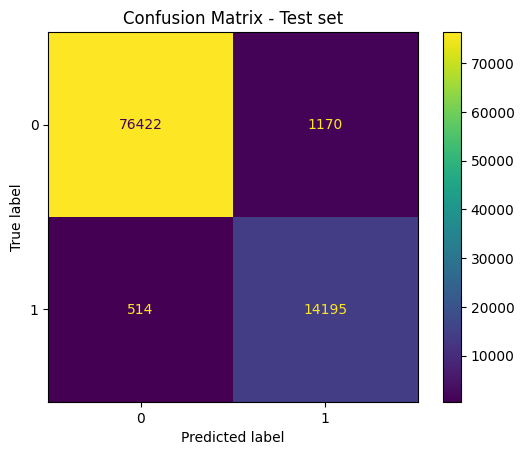

In [28]:
# =============================================================================
#  Confusion Matrix 
# =============================================================================

# Ottieni predizioni e label su tutto il test set
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = torch.sigmoid(model(data))
        preds = (out > 0.5).long().cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Test set")
plt.show()

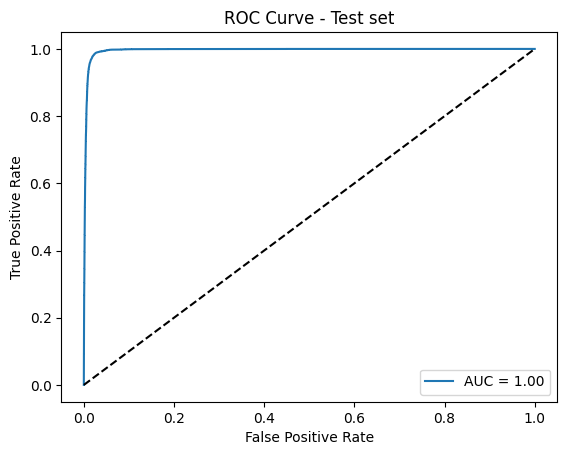

In [29]:
# =============================================================================
#  ROC Curve e AUC 
# =============================================================================

all_probs = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = torch.sigmoid(model(data))
        all_probs.append(out.cpu().numpy())
all_probs = np.concatenate(all_probs)

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test set')
plt.legend()
plt.show()

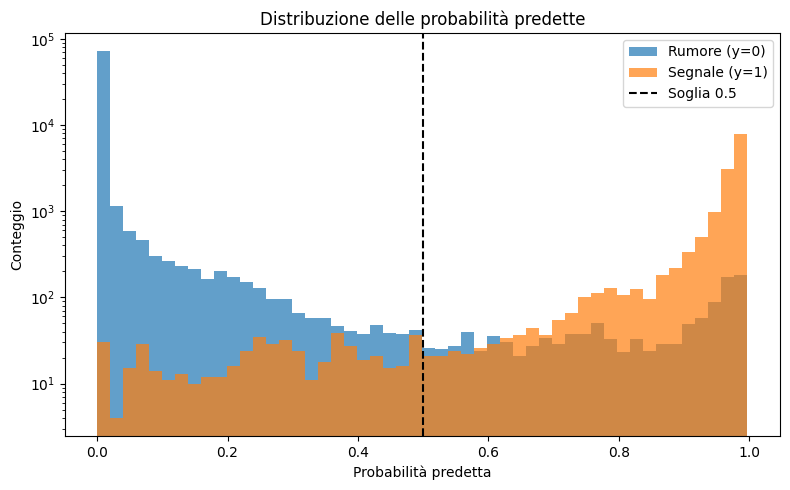

In [30]:
# =============================================================================
# Istogramma delle probabilità 
# =============================================================================

all_probs = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = torch.sigmoid(model(data))
        all_probs.append(out.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())
all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

plt.figure(figsize=(8,5))
bins = 50
plt.hist(all_probs[all_labels == 0], bins=bins, alpha=0.7, label='Rumore (y=0)')
plt.hist(all_probs[all_labels == 1], bins=bins, alpha=0.7, label='Segnale (y=1)')
plt.axvline(0.5, color='k', linestyle='--', label='Soglia 0.5')
plt.xlabel('Probabilità predetta')
plt.ylabel('Conteggio')
plt.title('Distribuzione delle probabilità predette')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# =============================================================================
# Explainer
# =============================================================================

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x, edge_index):
        from torch_geometric.data import Data
        data = Data(x=x, edge_index=edge_index)
        return self.model(data)
    
wrapped_model = WrappedModel(model).to(device)
example_data = test_graphs[0].to(device)
explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
node_index = 0
explanation = explainer(example_data.x, example_data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_feature_importance('feature_importance_ATLAS.png', top_k=4)
explanation.visualize_graph('subgraph_ATLAS.pdf')

# Riporta il grafo su CPU
test_graphs[0] = test_graphs[0].cpu()

Generated explanations in ['edge_mask', 'node_mask']


In [32]:

# =============================================================================
# VISUALIZZAZIONE RISULTATI SU 20 EVENTI
# =============================================================================

output_dir = "images/atlas"
os.makedirs(output_dir, exist_ok=True)

for j in range(20):
    data_es = test_graphs[j]
    x = data_es.x.cpu().numpy()
    labels_true = data_es.y.cpu().numpy()
    pos = data_es.pos.cpu().numpy()

    with torch.no_grad():
        out = torch.sigmoid(model(data_es.to(device)))
        pred_labels = (out.squeeze() > 0.5).cpu().numpy()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pos[labels_true == 0, 0], pos[labels_true == 0, 1], pos[labels_true == 0, 2],
               c='gray', s=40, label='Rumore', alpha=0.7)
    ax.scatter(pos[labels_true == 1, 0], pos[labels_true == 1, 1], pos[labels_true == 1, 2],
               c='orange', s=60, label='Segnale', alpha=0.8)

    for i in range(len(pos)):
        if pred_labels[i] == 1:
            ax.plot([pos[i, 0]], [pos[i, 1]], [pos[i, 2]], marker='o', markersize=18,
                    markerfacecolor='none', markeredgecolor='blue', markeredgewidth=2, alpha=0.7)

    margin = 0.05
    for idx, set_lim in enumerate([ax.set_xlim, ax.set_ylim, ax.set_zlim]):
        data = pos[:, idx]
        delta = (data.max() - data.min()) * margin
        set_lim(data.min() - delta, data.max() + delta)

    ax.set_xlabel('Global X')
    ax.set_ylabel('Global Y')
    ax.set_zlabel('Global Z')
    ax.set_title(f'Evento {j}: arancione=vero segnale, grigio=rumore, blu=predetto segnale')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/event_{j:02d}.png")
    plt.close(fig)

    # Riporta il grafo su CPU
    test_graphs[j] = test_graphs[j].cpu()

print("Salvati i primi 20 esempi in images/atlas/")


Salvati i primi 20 esempi in images/atlas/


In [33]:

# =============================================================================
# k-fold cross-validation
# =============================================================================

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y.float().to(device)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_metrics(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = torch.sigmoid(model(data))
            all_probs.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    preds = (all_probs > 0.5).astype(int)
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    return acc, prec, rec, f1

# Imposta parametri
k = 5
epochs = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
all_graphs = train_graphs + val_graphs + test_graphs  # Usa tutti i dati per il k-fold

accs, precs, recs, f1s = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(all_graphs)):
    print(f"\nFold {fold+1}/{k}")
    train_subset = [all_graphs[i] for i in train_idx]
    test_subset = [all_graphs[i] for i in test_idx]
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=16)
    
    # Nuova istanza del modello per ogni fold
    model = GNN(in_channels=4, hidden_channels=32, out_channels=1, num_layers=4, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        #print(f"  Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}")
    
    acc, prec, rec, f1 = eval_metrics(model, test_loader, device)
    print(f"  Fold metrics: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

print("\n=== K-Fold Results ===")
print(f"Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall: {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


Fold 1/5
  Fold metrics: acc=0.9804, prec=0.9068, rec=0.9758, f1=0.9401

Fold 2/5
  Fold metrics: acc=0.9794, prec=0.9126, rec=0.9572, f1=0.9344

Fold 3/5
  Fold metrics: acc=0.9791, prec=0.9246, rec=0.9419, f1=0.9332

Fold 4/5
  Fold metrics: acc=0.9806, prec=0.9068, rec=0.9708, f1=0.9377

Fold 5/5
  Fold metrics: acc=0.9785, prec=0.8851, rec=0.9779, f1=0.9292

=== K-Fold Results ===
Accuracy: 0.9796 ± 0.0008
Precision: 0.9072 ± 0.0128
Recall: 0.9647 ± 0.0135
F1: 0.9349 ± 0.0037
